In [1]:
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionPipeline
import torch
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

model = "CompVis/stable-diffusion-v1-4"
vae: AutoencoderKL = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to('cuda')
nparams = sum(el.numel() for el in vae.parameters())
print(vae)
print("nparams", nparams)

import torchsummary

size = 512

input_size = (3, size, size)
inputs = torch.rand(input_size).unsqueeze(0).to('cuda')

enc_out = vae.encode(inputs, True)
latent_dist = enc_out.latent_dist
print(f"{dir(latent_dist)=}")

enc_out = latent_dist.sample()
print(f"{enc_out.shape=}")

dec_out = vae.decoder(enc_out)
print(f"{dec_out.shape=}")
# torchsummary.summary(vae, input_size=input_size, batch_size=1)

nrows, ncols = 2, 2
width, height = ncols * size, nrows * size
big = Image.new("RGB", (width, height))
to_image = transforms.ToPILImage()

import dn_util
train_dl, val_dl = dn_util.get_dataloaders(disable_noise=True, image_size=size, image_dir='1star-2008-now-1024px', batch_size=1)
train_iter = iter(train_dl)


/home/tim/micromamba/envs/nn-nightly/lib/python3.10/site-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/home/tim/micromamba/envs/nn-nightly/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/tim/micromamba/envs/nn-nightly/lib/python3.10/site-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be re

nparams 83653863
dir(latent_dist)=['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'deterministic', 'kl', 'logvar', 'mean', 'mode', 'nll', 'parameters', 'sample', 'std', 'var']
enc_out.shape=torch.Size([1, 4, 64, 64])
dec_out.shape=torch.Size([1, 3, 512, 512])


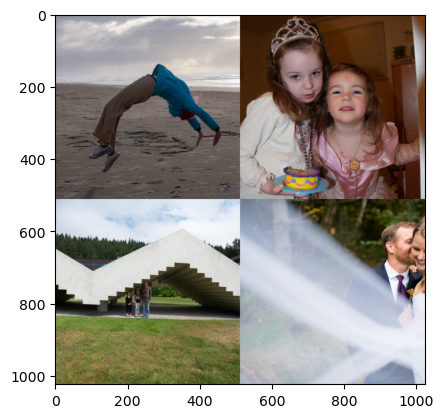

In [10]:

for y in range(nrows):
    for x in range(ncols):
        xy = (x * size, y * size)

        if True:
            inputs, _truth = next(train_iter)
            inputs = inputs.to('cuda')
            latent = vae.encode(inputs).latent_dist.sample()
        else:
            latent = torch.randn_like(enc_out).to('cuda')

        dec_img = vae.decode(latent, False)[0]
        dec_img.clamp_(min=0, max=1)
        dec_img = to_image(dec_img[0])
        big.paste(dec_img, xy)
plt.imshow(big)